In [16]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.registration import phase_cross_correlation
from scipy import io
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
import copy
import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.set_soft_device_placement(False)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [17]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
tf.config.get_soft_device_placement(), gpus[0]

(False, PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'))

In [20]:
gpus[0].name

'/physical_device:GPU:0'

In [21]:
!pwd

/gpfs/fs1/home/skandel/code/mbptycho/mbptycho/tests/two_edge_sparse_scan/apodized_probe_weak_peaks


In [34]:
strain_type = 'two_edge_slip'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'


In [35]:
!ls $data_path

sample_two_edge_slip.pkl  sim_two_edge_slip.pkl


In [36]:
!ls $sim_data_path

/home/skandel/code/mbptycho/experiments/python/two_edge_slip_sparse/apodized_probe_weak_peaks/sim_two_edge_slip.pkl


In [38]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#, sim_params={"HKL_list":[[1, 2, 0]]})
sm.sample.params.sample_pix_size

File exists. Reloading...


0.005844363636363636

In [29]:
sm.__dict__.keys()

dict_keys(['params', 'x_full', 'y_full', 'z_full', 'YY_full', 'XX_full', 'ZZ_full', 'obj_mask_w_delta', 'obj_mask_full', 'strain_params', 'Uy_full', 'Ux_full', 'Uz_full', 'rhos'])

## Directly reconstructing the displacements

In [39]:
recons = DisplacementFullModelReconstruction(simulation=sm, 
                                             shared_magnitudes=True, 
                                             unwrap_phase_proj=False, 
                                             batch_size=50)

Setting background_level to 1e-08...


In [40]:
disp_lr = 2e-2
magnitude_lr = 2e-2
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.02>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x145c48417040>,
  'var': <tf.Variable 'ux_uy:0' shape=(16530,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.02>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x145c48417820>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(8268,) dtype=float32, numpy=
  array([-16.118095, -16.118095, -16.118095, ...,   0.      ,   0.      ,
           0.      ], dtype=float32)>}}

In [43]:
recons.minimize(500, debug_output_epoch_frequency=10)

          epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
3060        510    1.85e+04      0.855      0.966        0.794        0.964      0.558      0.542       0.58      0.592          0.546          0.529          0.569          0.582
3120        520   1.57e+04      0.855      0.966      0.794      0.964      0.559      0.546      0.588      0.597      0.548      0.534      0.577      0.587
3180        530   2.26e+04      0.856      0.966      0.795      0.964      0.558       0.54      0.577       0.59      0.545      0.527      0.566       0.58
3240        540   3.01e+04      0.856      0.966      0.795      0.964      0.558      0.544      0.584      0.596      0.546       0.53      0.572      0.585
3300        550   2.18e+04      0.856      0.966      0.795      0.964      0.557      0.543      0.584      0.597      0.544      0.529      0.572      0.586
3360

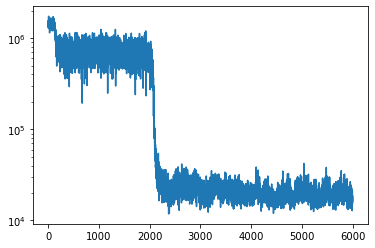

In [44]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [45]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = phase_cross_correlation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

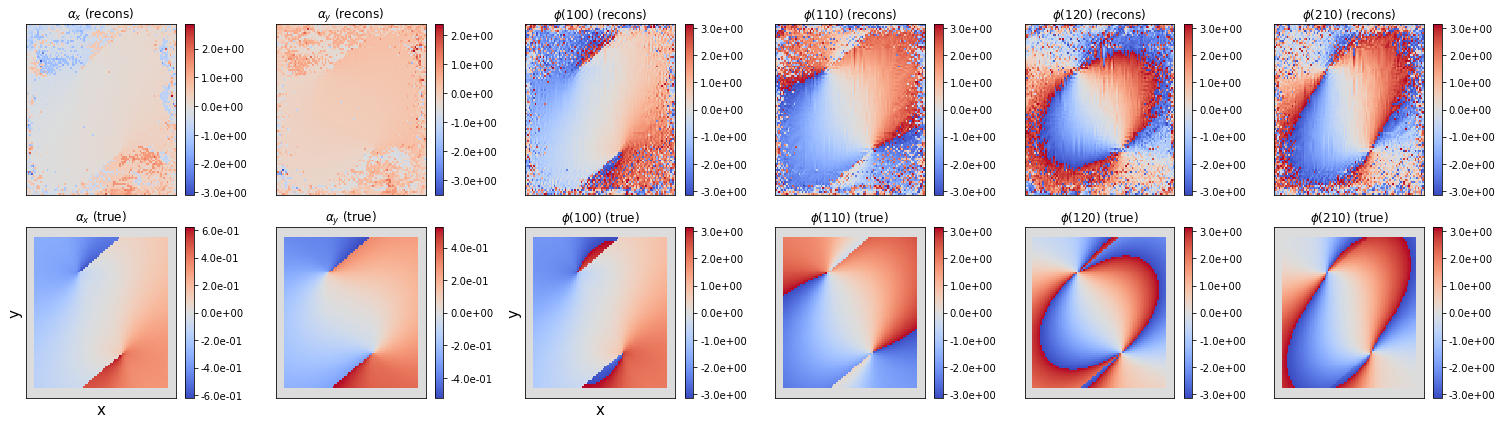

In [46]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

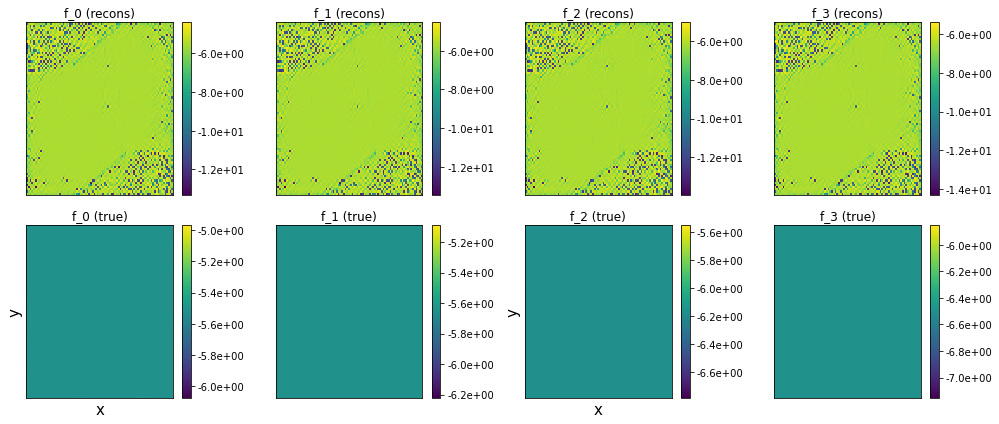

In [47]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][5:-5,5:-5])
    true_amplitudes = np.abs(recons._rho_true[i][5:-5,5:-5])
    
    cp0 = axs[0, i].pcolormesh(np.log(recons_amplitudes))
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(np.log(true_amplitudes))
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [48]:
recons.saveOutputsAndLog(data_path, prefix='direct_')

In [49]:
!ls $data_path

direct_df_displacement_to_data_shared_mags.gz
direct_rho_displacement_to_data_shared_mags.npz
direct_ux_displacement_to_data_shared_mags.npz
direct_uy_displacement_to_data_shared_mags.npz
sample_two_edge_slip.pkl
sim_two_edge_slip.pkl


In [50]:
import pandas as pd

In [51]:
dload = pd.read_pickle(f'{data_path}/direct_df_displacement_to_data_shared_mags.gz')

In [52]:
dload.dropna()

,epoch,train_loss,err_ux,err_uy,err_ux_film,err_uy_film,err_rho0,err_rho1,err_rho2,err_rho3,err_rho_film0,err_rho_film1,err_rho_film2,err_rho_film3
6,1.0,1.309744e+06,0.805036,0.835449,0.765700,0.832228,0.896240,0.963959,0.927723,0.930906,0.875234,0.957558,0.907686,0.915797
12,2.0,1.438001e+06,0.792301,0.801899,0.744838,0.806049,0.854436,0.920703,0.947665,0.919627,0.828242,0.887795,0.921623,0.902060
18,3.0,1.442697e+06,0.785023,0.804062,0.742466,0.789489,0.830978,0.883155,0.896615,0.860639,0.801676,0.828729,0.878594,0.826033
24,4.0,1.428791e+06,0.797307,0.811272,0.737374,0.788450,0.817667,0.862772,0.822461,0.810526,0.780580,0.789827,0.778762,0.762674
30,5.0,1.435794e+06,0.793043,0.813777,0.721955,0.785977,0.805020,0.848680,0.759783,0.794813,0.762057,0.773330,0.701289,0.745513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,996.0,1.789679e+04,0.868529,0.971074,0.806519,0.965197,0.503979,0.514825,0.549633,0.556216,0.477854,0.489691,0.527303,0.534471
5982,997.0,2.024306e+04,0.868578,0.971144,0.806806,0.965786,0.503968,0.512079,0.547358,0.552765,0.477729,0.486616,0.524785,0.530740
5988,998.0,1.956831e+04,0.868665,0.971162,0.806985,0.965734,0.504169,0.511051,0.542458,0.552664,0.477968,0.485513,0.519443,0.530631
5994,999.0,2.140692e+04,0.868638,0.971515,0.806956,0.965698,0.502947,0.508534,0.537216,0.547035,0.476569,0.482745,0.513776,0.524513


In [53]:
ux = recons_items[r'$\alpha_x$']
uy = recons_items[r'$\alpha_y$']

In [54]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

In [55]:
sm.sample.params.lattice

array([0.0003905, 0.0003905, 0.0003905])

In [56]:

import matplotlib.colors as colors

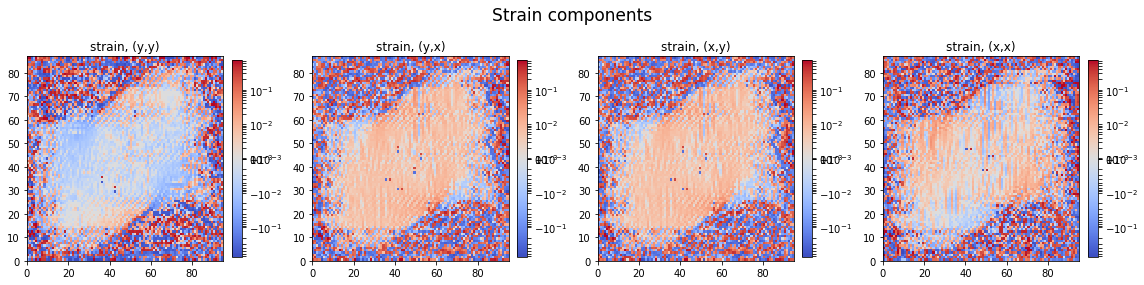

In [57]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [58]:
s.max(), s.min()

(3.1098742485046387, -1.8817012310028076)

In [59]:
ux = true_items[r'$\alpha_x$']
uy = true_items[r'$\alpha_y$']

In [60]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

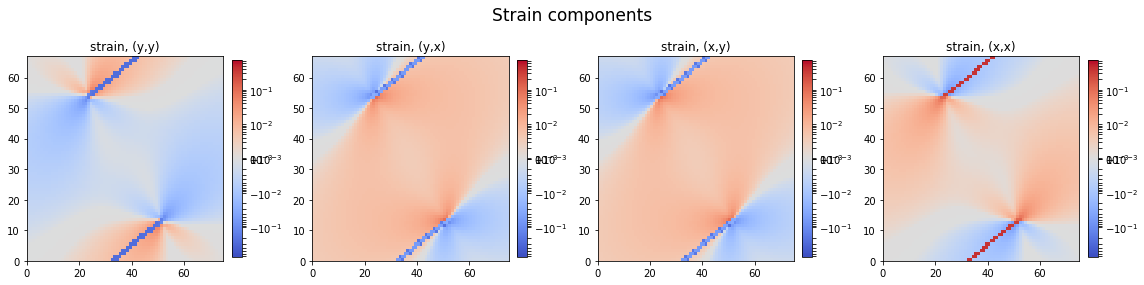

In [61]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-0.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [62]:
sl.max()

0.40638076756532915

In [63]:
s.max(), s.min()

(0.40835473746468076, -0.27823352787413763)